<a href="https://colab.research.google.com/github/Mohd6288/DAMLCP_Project/blob/main/Body_Dress_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report on Prototype Experiment: Aligning Clothing with Body Pose

# Introduction
This experiment aimed to prototype a system that dynamically overlays clothing templates (T-shirt, jacket, jeans) onto a person's body using pose detection. The system used Mediapipe Pose for detecting key body landmarks and mapped clothing templates to these landmarks. The goal was to visualize how clothing could align with the human body in an interactive application, such as a virtual fitting room.

# Findings
Pose Detection Success:

The Mediapipe Pose successfully detected and annotated key body landmarks (e.g., shoulders, hips, knees) on the main image.
These landmarks provided the necessary data for calculating the dimensions and positions of clothing templates.
Clothing Misalignment:

Observed Issue: Clothing templates (T-shirt, jacket, and jeans) were not properly aligned with the body pose. The clothing appeared to "float" or be placed incorrectly relative to the person's body.
Possible Reasons:
Inaccurate Scaling: Clothing templates were resized based on approximate dimensions, leading to incorrect proportions.
Improper Placement: The templates were positioned using only a few key landmarks (e.g., shoulders for the T-shirt, hips for jeans). This simplistic approach ignored the curvature and depth of the body.
Template Orientation: Clothing templates were not warped to match the natural angles and motion of the body.
Image Quality and Perspective: The image used for testing may have posed challenges due to perspective distortion or insufficient visibility of body parts.
Template Compatibility:

Templates like jacket.jpeg lacked transparency, making it harder to seamlessly overlay them on the image.
Non-uniform clothing shapes (e.g., jeans) further exacerbated alignment challenges.
Potential Improvements
Advanced Landmark Usage:

Utilize additional landmarks (e.g., elbows, wrists, knees) to better map clothing templates to the body's curvature and angles.
Incorporate relationships between multiple landmarks to improve alignment precision.
Dynamic Warping:

Implement advanced warping techniques (e.g., affine or perspective transformation) to adapt clothing templates to the body's shape and motion dynamically.
3D Pose Estimation:

Upgrade the system to use 3D pose estimation to account for depth and perspective, improving template alignment for various camera angles.
High-Quality Templates:

Use transparent PNG templates with well-defined shapes and sizes to simplify overlay logic.
Create a library of clothing templates tailored for this system, ensuring consistent dimensions and scaling.
User Interaction:

Develop an interactive interface for users to manually adjust clothing alignment, fine-tuning the position and fit as needed.
Conclusion
This prototype provided valuable insights into the challenges of aligning clothing with body poses using 2D pose detection. While the system successfully detected body landmarks and displayed clothing templates, significant improvements are needed to achieve seamless alignment. Future work will focus on refining scaling and placement logic, leveraging advanced transformations, and exploring 3D pose detection for greater accuracy.

This report highlights the current limitations and sets the foundation for further experimentation and iteration. Let me know if you'd like to revisit or expand this project later!

In [ ]:
!pip install tensorflow

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 54.4 MB/s eta 0:00:00


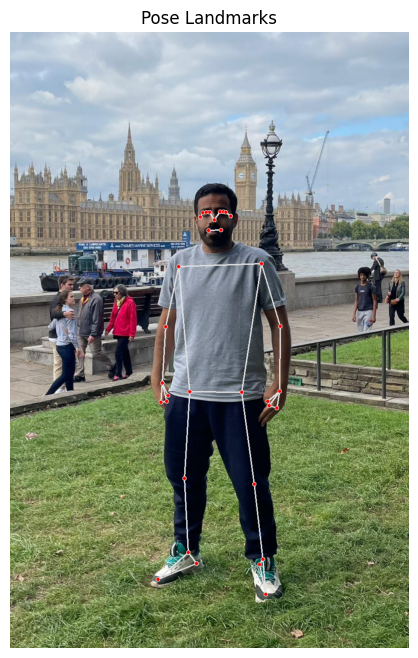

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils  # For drawing landmarks
pose = mp_pose.Pose()

# Read and process the image
image = cv2.imread('test.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)

# Draw pose landmarks on the image
if results.pose_landmarks:
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS)

    # Convert BGR to RGB for displaying
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Display the annotated image
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image_rgb)
    plt.axis('off')
    plt.title("Pose Landmarks")
    plt.show()
else:
    print("No pose landmarks detected.")


In [ ]:
# Extract key landmarks
landmarks = results.pose_landmarks.landmark

# Get coordinates of shoulders and hips
left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]

# Calculate key dimensions (scaled to image size)
image_height, image_width, _ = image.shape
shoulder_width = abs(right_shoulder.x - left_shoulder.x) * image_width
torso_height = abs(left_shoulder.y - left_hip.y) * image_height

print(f"Shoulder Width: {shoulder_width}, Torso Height: {torso_height}")


Shoulder Width: 171.89968538284302, Torso Height: 266.19441986083984


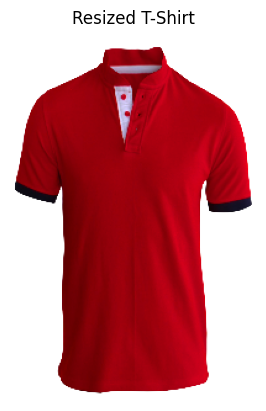

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load clothing templates
tshirt = cv2.imread('T-shirt.png', cv2.IMREAD_UNCHANGED)  # Support for transparency
jacket = cv2.imread('jacket.jpeg')  # JPEG has no alpha channel
jeans = cv2.imread('jeans.png', cv2.IMREAD_UNCHANGED)

# Function to resize clothing based on dimensions
def resize_clothing(clothing_image, width, height):
    return cv2.resize(clothing_image, (int(width), int(height)))

# Test resizing
resized_tshirt = resize_clothing(tshirt, 200, 300)  # Example dimensions
plt.imshow(cv2.cvtColor(resized_tshirt, cv2.COLOR_BGRA2RGBA))  # Handle transparency
plt.axis('off')
plt.title("Resized T-Shirt")
plt.show()


In [ ]:
# Extract key landmarks for torso and legs
landmarks = results.pose_landmarks.landmark

left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]

# Calculate dimensions and position
image_height, image_width, _ = image.shape
shoulder_width = abs(right_shoulder.x - left_shoulder.x) * image_width
torso_height = abs(left_shoulder.y - left_hip.y) * image_height

# Set position for clothing overlay (centered at shoulders)
overlay_x = int(left_shoulder.y * image_height)
overlay_y = int(left_shoulder.x * image_width - shoulder_width / 2)


In [ ]:
def overlay_image(background, overlay, x, y):
    """
    Overlay an image (overlay) onto a background image (background) at position (x, y).
    Handles both transparent (RGBA) and non-transparent (RGB) images.
    """
    for i in range(overlay.shape[0]):
        for j in range(overlay.shape[1]):
            if x + i >= background.shape[0] or y + j >= background.shape[1]:
                continue
            # Check for transparency if overlay has 4 channels (RGBA)
            if overlay.shape[2] == 4 and overlay[i, j, 3] == 0:
                continue
            # Overlay the RGB channels
            background[x + i, y + j, :] = overlay[i, j, :3]
    return background


In [ ]:
def add_alpha_channel(image):
    """
    Adds an alpha channel to an RGB image.
    """
    if image.shape[2] == 3:  # Check if the image has 3 channels (RGB)
        alpha_channel = np.ones(image.shape[:2], dtype=image.dtype) * 255  # Fully opaque
        image = np.dstack((image, alpha_channel))
    return image


In [ ]:
jacket = cv2.imread('jacket.jpeg')
jacket = add_alpha_channel(jacket)


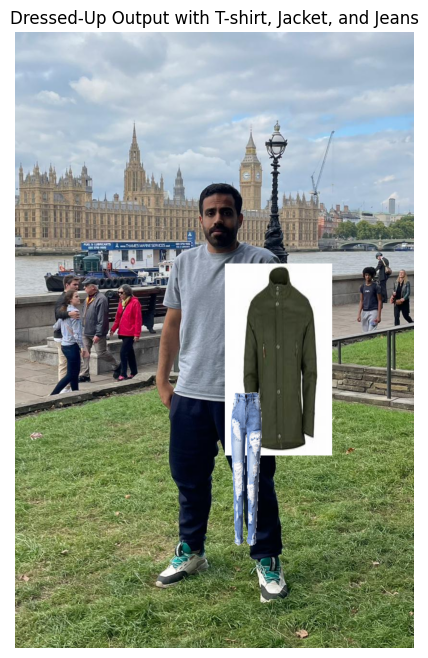

In [ ]:
# Load and prepare clothing templates
tshirt = cv2.imread('T-shirt.png', cv2.IMREAD_UNCHANGED)
jacket = cv2.imread('jacket.jpeg')
jacket = add_alpha_channel(jacket)  # Add alpha channel
jeans = cv2.imread('jeans.png', cv2.IMREAD_UNCHANGED)

# Resize clothing templates based on landmarks
resized_tshirt = cv2.resize(tshirt, (int(shoulder_width * 1.2), int(torso_height * 0.5)))
resized_jacket = cv2.resize(jacket, (int(shoulder_width * 1.3), int(torso_height * 1.5)))
resized_jeans = cv2.resize(jeans, (int(shoulder_width), int(torso_height * 1.2)))

# Overlay clothing on the main image
output_image = overlay_image(main_image.copy(), resized_tshirt, int(left_shoulder.y * image_height), int(left_shoulder.x * image_width - shoulder_width / 2))
output_image = overlay_image(output_image, resized_jacket, int(left_shoulder.y * image_height), int(left_shoulder.x * image_width - shoulder_width / 2))
output_image = overlay_image(output_image, resized_jeans, int(left_hip.y * image_height), int(left_hip.x * image_width - shoulder_width / 2))

# Display the final output
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Dressed-Up Output with T-shirt, Jacket, and Jeans")
plt.show()


In [ ]:
# Extract key landmarks
landmarks = results.pose_landmarks.landmark

left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]

# Convert normalized landmarks to pixel coordinates
def landmark_to_pixel(landmark, width, height):
    return int(landmark.x * width), int(landmark.y * height)

image_height, image_width, _ = image.shape
pts_body = [
    landmark_to_pixel(left_shoulder, image_width, image_height),
    landmark_to_pixel(right_shoulder, image_width, image_height),
    landmark_to_pixel(left_hip, image_width, image_height)
]

print("Body Points:", pts_body)


Body Points: [(522, 481), (350, 487), (481, 748)]


In [ ]:
# Define anchor points on the T-shirt image
tshirt_height, tshirt_width, _ = tshirt.shape
pts_tshirt = [
    (0, 0),  # Top-left corner
    (tshirt_width - 1, 0),  # Top-right corner
    (0, tshirt_height - 1)  # Bottom-left corner
]

print("T-Shirt Points:", pts_tshirt)


T-Shirt Points: [(0, 0), (1199, 0), (0, 1615)]


In [ ]:
# Define anchor points on the T-shirt image
tshirt_height, tshirt_width, _ = tshirt.shape
pts_tshirt = [
    (0, 0),  # Top-left corner
    (tshirt_width - 1, 0),  # Top-right corner
    (0, tshirt_height - 1)  # Bottom-left corner
]

print("T-Shirt Points:", pts_tshirt)


T-Shirt Points: [(0, 0), (1199, 0), (0, 1615)]


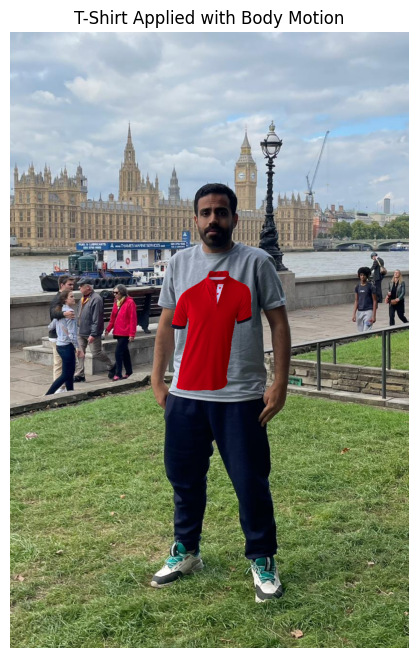

In [ ]:
# Compute the affine transformation matrix
matrix = cv2.getAffineTransform(np.float32(pts_tshirt), np.float32(pts_body))

# Warp the T-shirt image
warped_tshirt = cv2.warpAffine(
    tshirt, matrix, (image_width, image_height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0)
)

# Overlay the warped T-shirt on the body
def overlay_transparent(background, overlay):
    """
    Overlay a transparent image onto a background.
    """
    for i in range(overlay.shape[0]):
        for j in range(overlay.shape[1]):
            if overlay[i, j, 3] > 0:  # Check transparency
                background[i, j, :] = overlay[i, j, :3]
    return background

output_image = overlay_transparent(image.copy(), warped_tshirt)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("T-Shirt Applied with Body Motion")
plt.show()


In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

# Function to process and draw landmarks
def process_and_draw_landmarks(image_path, pose):
    # Read and process the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    # Draw landmarks on the image
    if results.pose_landmarks:
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS
        )
        return cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB), results.pose_landmarks
    else:
        print(f"No pose landmarks detected for {image_path}")
        return image, None


No pose landmarks detected for T-shirt.png


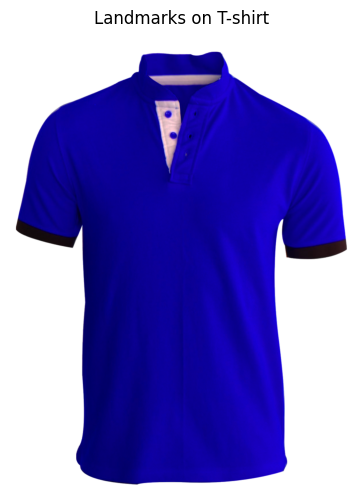

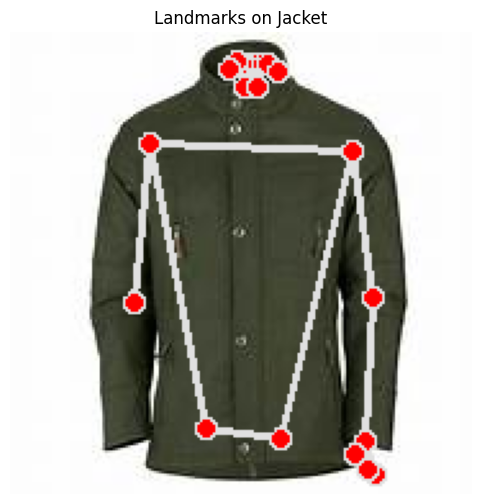

No pose landmarks detected for jeans.png


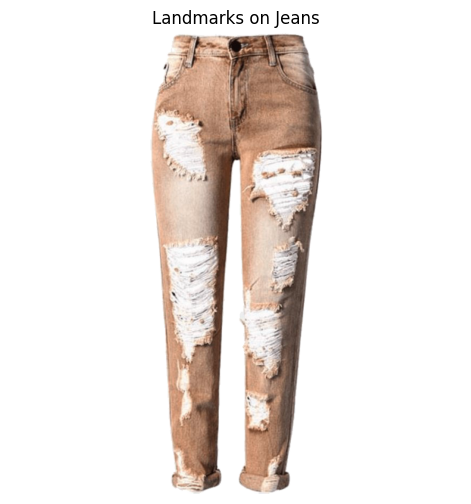

In [ ]:
# Clothing template paths
clothing_paths = {
    "T-shirt": "T-shirt.png",
    "Jacket": "jacket.jpeg",
    "Jeans": "jeans.png"
}

# Process each clothing image and display results
for clothing_name, path in clothing_paths.items():
    processed_image, pose_landmarks = process_and_draw_landmarks(path, pose)
    plt.figure(figsize=(8, 6))
    plt.imshow(processed_image)
    plt.axis('off')
    plt.title(f"Landmarks on {clothing_name}")
    plt.show()


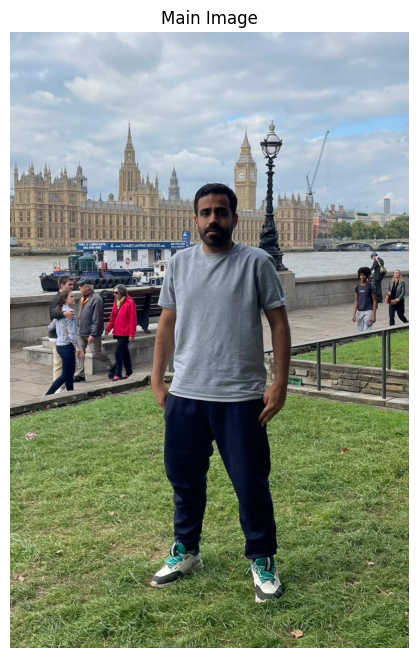

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

# Load the main image
main_image = cv2.imread('test.jpg')
main_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)

# Display the main image
plt.figure(figsize=(10, 8))
plt.imshow(main_image_rgb)
plt.axis('off')
plt.title("Main Image")
plt.show()


In [ ]:
# Extract key landmarks for torso and legs
landmarks = results.pose_landmarks.landmark

# Image dimensions
image_height, image_width, _ = main_image.shape

# Shoulders and hips for upper body clothing
left_shoulder = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width),
                 int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height))
right_shoulder = (int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width),
                  int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height))
left_hip = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * image_width),
            int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * image_height))
right_hip = (int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x * image_width),
             int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y * image_height))

# Hips, knees, and ankles for lower body clothing
left_knee = (int(landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x * image_width),
             int(landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y * image_height))
right_knee = (int(landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x * image_width),
              int(landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y * image_height))
left_ankle = (int(landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x * image_width),
              int(landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y * image_height))
right_ankle = (int(landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image_width),
               int(landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image_height))


In [ ]:
# Calculate width and height for T-shirt/Jacket
tshirt_width = int(abs(right_shoulder[0] - left_shoulder[0]) * 1.2)  # Add padding
tshirt_height = int(abs(left_shoulder[1] - left_hip[1]) * 1.5)       # Cover torso

# Resize T-shirt
resized_tshirt = cv2.resize(tshirt, (tshirt_width, tshirt_height))

# Position T-shirt based on shoulders
tshirt_x = left_shoulder[0]  # Align with left shoulder
tshirt_y = left_shoulder[1]  # Top aligned with shoulder height


In [ ]:
# Calculate width and height for Jeans
jeans_width = int(abs(right_hip[0] - left_hip[0]) * 1.2)
jeans_height = int(abs(left_hip[1] - left_ankle[1]) * 1.2)

# Resize Jeans
resized_jeans = cv2.resize(jeans, (jeans_width, jeans_height))

# Position Jeans based on hips
jeans_x = left_hip[0]  # Align with left hip
jeans_y = left_hip[1]  # Top aligned with hip height


In [ ]:
# Overlay T-shirt
output_image = overlay_image(main_image.copy(), resized_tshirt, tshirt_y, tshirt_x)

# Overlay Jeans
output_image = overlay_image(output_image, resized_jeans, jeans_y, jeans_x)


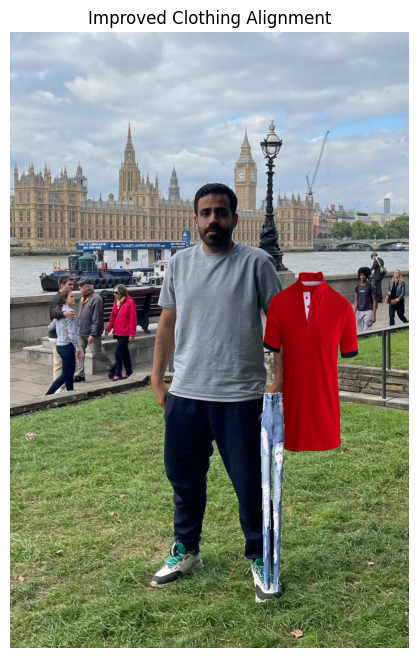

In [ ]:
# Display the dressed-up image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Improved Clothing Alignment")
plt.show()
